# Importación de las librerías necesarias para la ejecución #

In [1]:
#Librerias Necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score, cross_validate

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from scipy.stats import f_oneway
from scipy.stats import kendalltau, spearmanr
from scipy.stats import pointbiserialr

# Lectura de los datos de los partidos ya formateados en .csv

In [2]:
import os

dataframes = []
carpeta = "Datos_Formateados/"  # Reemplaza "ruta/de/la/carpeta" con la ruta de la carpeta que deseas explorar

archivos = os.listdir(carpeta)
for archivo in archivos:
    df = pd.read_csv("Datos_Formateados/"+archivo)
    df.fillna(0,inplace=True)
    dataframes.append(df)
datos_partidos = pd.concat(dataframes, ignore_index=True)
datos_partidos.fillna(0, inplace=True)
datos_partidos.shape

(1524, 25)

In [3]:
datos_partidos.head()

,Tournament,Date,Series,Court,Surface,Round,P,S,PRank,SRank,...,S2,P3,S3,P4,S4,P5,S5,Psets,Ssets,Gana_P
0,Australian Open,20/01/2020,Grand Slam,Outdoor,Hard,1st Round,Harris A.,Berrettini M.,162.0,8.0,...,6.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1,Australian Open,20/01/2020,Grand Slam,Outdoor,Hard,1st Round,Berankis R.,Carballes Baena R.,69.0,83.0,...,2.0,6.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0
2,Australian Open,20/01/2020,Grand Slam,Outdoor,Hard,1st Round,Mcdonald M.,Evans D.,129.0,32.0,...,4.0,1.0,6.0,2.0,6.0,3.0,6.0,2.0,3.0,0.0
3,Australian Open,20/01/2020,Grand Slam,Outdoor,Hard,1st Round,Djere L.,Nishioka Y.,40.0,71.0,...,3.0,2.0,6.0,6.0,7.0,0.0,0.0,1.0,3.0,0.0
4,Australian Open,20/01/2020,Grand Slam,Outdoor,Hard,1st Round,Pella G.,Smith J.P.,25.0,308.0,...,5.0,6.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0


In [4]:
def get_tenistas(dataframe: pd.DataFrame) -> list:
    list = []
    for idx,partido in dataframe.iterrows():
        if partido['P'] not in list:
            list.append(partido['P'])
        if partido['S'] not in list:
            list.append(partido['S'])
    return list

tenistas = get_tenistas(dataframe=datos_partidos)
len(tenistas)

283

# Predicción del ganador de un partido 

## - Pre-procesamiento de los datos ##

### Limpiado de valores de la columna FTR diferentes a [A,D,H]

### Obtención del gol average medio de cada partido

In [6]:
def get_puntos_marcados_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_puntos_por_partido = []
    partidos_del_tenista = dataframe.loc[(dataframe['P'] == tenistas) | (dataframe['S'] == tenistas)]
    for idx, partido in partidos_del_tenista.iterrows():
        if partido['P'] == tenistas:
            lista_puntos_por_partido.append(partido['P1']+partido['P2']+partido['P3']+partido['P4']+partido['P5'])
        if partido['S'] == tenistas:
            lista_puntos_por_partido.append(partido['S1']+partido['S2']+partido['S3']+partido['S4']+partido['S5'])
    return lista_puntos_por_partido

def get_puntos_encajados_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_puntos_por_partido = []
    partidos_del_tenista = dataframe.loc[(dataframe['P'] == tenistas) | (dataframe['S'] == tenistas)]
    for idx, partido in partidos_del_tenista.iterrows():
        if partido['P'] == tenistas:
            lista_puntos_por_partido.append(partido['S1']+partido['S2']+partido['S3']+partido['S4']+partido['S5'])
        if partido['S'] == tenistas:
            lista_puntos_por_partido.append(partido['P1']+partido['P2']+partido['P3']+partido['P4']+partido['P5'])
    return lista_puntos_por_partido

def get_sets_sin_encajar(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_sets_sin_encajar = []
    partidos_del_tenista = dataframe.loc[(dataframe['P'] == tenistas) | (dataframe['S'] == tenistas)]
    for idx, partido in partidos_del_tenista.iterrows():
        valor = 0
        if partido['P'] == tenistas:
            if partido['S1'] == 0:
                valor += 1
            if partido['S2'] == 0:
                valor += 1
            if partido['S3'] == 0:
                valor += 1
            if partido['S4'] == 0 and partido['P4'] != 0:
                valor += 1
            if partido['S5'] == 0 and partido['P5'] != 0:
                valor += 1
        if partido['S'] == tenistas:
            if partido['P1'] == 0:
                valor += 1
            if partido['P2'] == 0:
                valor += 1
            if partido['P3'] == 0:
                valor += 1
            if partido['P4'] == 0 and partido['S4'] != 0:
                valor += 1
            if partido['P5'] == 0 and partido['S5'] != 0:
                valor += 1
        lista_sets_sin_encajar.append(valor) 
    return lista_sets_sin_encajar

def obtencion_sets_sin_encajar(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_sets_sin_encajar_tenistas = []
    tenistass = get_tenistas(dataframe=dataframe)
    for tenistas in tenistass:
        lista_sets_sin_encajar_un_tenistas = get_sets_sin_encajar(dataframe=dataframe, tenistas=tenistas)
        lista_sets_sin_encajar_un_tenistas.insert(0,0)
        if guardar:
            dict_ultimo_sets_sin_encajar_tenistas[tenistas] = lista_sets_sin_encajar_un_tenistas[-1]
        lista_sets_sin_encajar_un_tenistas.pop()
        lista_listas_sets_sin_encajar_tenistas.append(lista_sets_sin_encajar_un_tenistas)
    return lista_listas_sets_sin_encajar_tenistas

def get_media_puntos_marcados_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_puntos_por_partido = get_puntos_marcados_por_partido(dataframe=dataframe, tenistas=tenistas)
    lista_media_puntos_por_partido = []
    puntos_acumulados = 0
    for idx, valor in enumerate(lista_puntos_por_partido):
        lista_media_puntos_por_partido.append((valor + puntos_acumulados) / (idx+1))
        puntos_acumulados += valor
    return lista_media_puntos_por_partido

def get_media_puntos_encajados_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_puntos_por_partido = get_puntos_encajados_por_partido(dataframe=dataframe, tenistas=tenistas)
    lista_media_puntos_por_partido = []
    puntos_acumulados = 0
    for idx, valor in enumerate(lista_puntos_por_partido):
        lista_media_puntos_por_partido.append((valor + puntos_acumulados) / (idx+1))
        puntos_acumulados += valor
    return lista_media_puntos_por_partido

def get_media_punto_average_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_puntos_marcados_por_partido = get_puntos_marcados_por_partido(dataframe=dataframe, tenistas=tenistas)
    lista_puntos_encajados_por_partido = get_puntos_encajados_por_partido(dataframe=dataframe, tenistas=tenistas)
    lista_media_punto_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_puntos_marcados_por_partido):
        lista_media_punto_average_por_partido.append((valor - lista_puntos_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
        valor_acumulado += (valor - lista_puntos_encajados_por_partido[idx])
    return lista_media_punto_average_por_partido

def obtencion_punto_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_punto_average_medio_cada_tenistas = []
    tenistass = get_tenistas(dataframe=dataframe)
    for tenistas in tenistass:
        lista_punto_average_medio_un_tenistas = get_media_punto_average_por_partido(dataframe=dataframe, tenistas=tenistas)
        lista_punto_average_medio_un_tenistas.insert(0,0)
        if guardar:
            dict_ultimo_punto_average_tenistas[tenistas] = lista_punto_average_medio_un_tenistas[-1]
        lista_punto_average_medio_un_tenistas.pop()
        lista_listas_punto_average_medio_cada_tenistas.append(lista_punto_average_medio_un_tenistas)
    return lista_listas_punto_average_medio_cada_tenistas
        
def get_diferencia_media_punto_average_por_partido(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_media_punto_average_por_partido = get_media_punto_average_por_partido(dataframe=dataframe, tenistas=tenistas)
    lista_diferencias = []
    valor_anterior = 0
    for valor in lista_media_punto_average_por_partido:
        lista_diferencias.append(valor - valor_anterior)
        valor_anterior = valor
    return lista_diferencias

def obtencion_diferencias_average_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_diferencias_punto_average_medio_cada_tenistas = []
    tenistass = get_tenistas(dataframe=dataframe)
    for tenistas in tenistass:
        lista_diferencias_punto_average_medio_un_tenistas = get_diferencia_media_punto_average_por_partido(dataframe=dataframe, tenistas=tenistas)
        lista_diferencias_punto_average_medio_un_tenistas.insert(0,0)
        if guardar:
            dict_ultimas_diferencias_cada_tenistas[tenistas] = lista_diferencias_punto_average_medio_un_tenistas[-1]
        lista_diferencias_punto_average_medio_un_tenistas.pop()
        lista_listas_diferencias_punto_average_medio_cada_tenistas.append(lista_diferencias_punto_average_medio_un_tenistas)
    return lista_listas_diferencias_punto_average_medio_cada_tenistas

def get_resultados_partidos_tenistas(dataframe: pd.DataFrame, tenistas: str) -> list:
    lista_victorias_tenistas = []
    lista_derrotas_tenistas = []
    victorias = 0
    derrotas = 0
    partidos_del_tenistas = dataframe.loc[(dataframe['P'] == tenistas) | (dataframe['S'] == tenistas)]
    for idx, partido in partidos_del_tenistas.iterrows():
        if partido['P'] == tenistas and partido['Gana_P'] == 1:
            victorias += 1
        elif partido['S'] == tenistas and partido['Gana_P'] == 0:
            victorias += 1
        else:
            derrotas += 1
        lista_victorias_tenistas.append(victorias)
        lista_derrotas_tenistas.append(derrotas)
    return lista_victorias_tenistas, lista_derrotas_tenistas

def obtencion_resultados_en_liga(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_resultados_en_liga = []
    tenistass = get_tenistas(dataframe=dataframe)
    for tenistas in tenistass:
        lista_resultados_por_partido = []
        lista_victorias_por_partido, lista_derrotas_por_partido = get_resultados_partidos_tenistas(dataframe=dataframe, tenistas=tenistas)
        lista_victorias_por_partido.insert(0,0)
        lista_derrotas_por_partido.insert(0,0)
        for idx, resultado in enumerate(lista_victorias_por_partido):
            lista_victorias_por_partido[idx] += dict_ultimos_resultados_cada_tenistas[tenistas][0]
            lista_derrotas_por_partido[idx] += dict_ultimos_resultados_cada_tenistas[tenistas][1]
            lista_resultados_por_partido.append((lista_victorias_por_partido[idx],lista_derrotas_por_partido[idx]))
        dict_ultimos_resultados_cada_tenistas[tenistas] = lista_resultados_por_partido[-1]
        lista_resultados_por_partido.pop()
        lista_listas_resultados_en_liga.append(lista_resultados_por_partido)
    return lista_listas_resultados_en_liga
    
def obtencion_media_puntos_marcados(dataframe: pd.DataFrame, guardar:bool) -> list:
    lista_listas_puntos_marcados = []
    tenistass = get_tenistas(dataframe=dataframe)
    for tenistas in tenistass:
        lista_puntos_por_partido_un_tenistas = get_media_puntos_marcados_por_partido(dataframe=dataframe, tenistas=tenistas)
        lista_puntos_por_partido_un_tenistas.insert(0,0)
        if guardar:
            dict_ultimos_puntos_marcados_cada_tenistas[tenistas] = lista_puntos_por_partido_un_tenistas[-1]
        lista_puntos_por_partido_un_tenistas.pop()
        lista_listas_puntos_marcados.append(lista_puntos_por_partido_un_tenistas)
    return lista_listas_puntos_marcados

def media_ultimos_5_partidos(favor: list, contra: list, idx: int):
    return ((favor[idx]-contra[idx])+(favor[idx-1]-contra[idx-1])+(favor[idx-2]-contra[idx-2])+(favor[idx-3]-contra[idx-3])+(favor[idx-4]-contra[idx-4])) /5

def get_media_gol_average_por_partido_ultimos_5(dataframe: pd.DataFrame, equipo: str) -> list:
    lista_goles_marcados_por_partido = get_puntos_marcados_por_partido(dataframe=dataframe, tenistas=equipo)
    lista_goles_encajados_por_partido = get_puntos_encajados_por_partido(dataframe=dataframe, tenistas=equipo)
    lista_media_gol_average_por_partido = []
    valor_acumulado = 0
    for idx, valor in enumerate(lista_goles_marcados_por_partido):
        if idx <= 4:
            lista_media_gol_average_por_partido.append((valor - lista_goles_encajados_por_partido[idx] + valor_acumulado) / (idx+1))
            valor_acumulado += (valor - lista_goles_encajados_por_partido[idx])
        else:
            lista_media_gol_average_por_partido.append(media_ultimos_5_partidos(favor=lista_goles_marcados_por_partido, contra=lista_goles_encajados_por_partido, idx=idx))

    return lista_media_gol_average_por_partido

def obtencion_gol_average_ultimos_5_dataframe(dataframe: pd.DataFrame, guardar: bool) -> list:
    lista_listas_gol_average_medio_cada_equipo = []
    equipos = get_tenistas(dataframe=dataframe)
    for equipo in equipos:
        lista_gol_average_medio_un_equipo = get_media_gol_average_por_partido_ultimos_5(dataframe=dataframe, equipo=equipo)
        lista_gol_average_medio_un_equipo.insert(0,0)
        if guardar:
            dict_ultimo_gol_average_ultimos_5_equipo[equipo] = lista_gol_average_medio_un_equipo[-1]
        lista_gol_average_medio_un_equipo.pop()
        lista_listas_gol_average_medio_cada_equipo.append(lista_gol_average_medio_un_equipo)
    return lista_listas_gol_average_medio_cada_equipo

def obtencion_puntos_ranking_tenistas(dataframe: pd.DataFrame):
    tenistas = get_tenistas(dataframe=dataframe)
    for tenista in tenistas:
        filaP = datos_partidos[(datos_partidos['P'] == tenista)]
        filaS = datos_partidos[(datos_partidos['S'] == tenista)]
        if not filaP.empty:
            dict_ultimos_puntos_ranking_cada_tenistas[tenista] = filaP.iloc[0]['PPts']
        elif not filaS.empty:
            dict_ultimos_puntos_ranking_cada_tenistas[tenista] = filaS.iloc[0]['SPts']
        
def insercion_datos_cada_dataframe(dataframe: pd.DataFrame, lista_listas_punto_average_medio_cada_tenistas: list, lista_listas_diferencias_punto_average_medio_cada_tenistas: list,
lista_listas_puntos_marcados_por_partido: list, lista_listas_resultados_por_partido: list, lista_listas_sets_sin_encajar_tenistas: list,
lista_listas_gol_average_ultimos_5_por_partido: list):
    tenistass = get_tenistas(dataframe=dataframe)
    for idx_tenistass,tenistas in enumerate(tenistass):
        partidos_del_tenistas = dataframe.loc[(dataframe['P'] == tenistas) | (dataframe['S'] == tenistas)]
        idx_partidos = 0
        for idx, partido in partidos_del_tenistas.iterrows():
            if partido['P'] == tenistas:
                dataframe.at[idx,'Punto_Average_P'] = lista_listas_punto_average_medio_cada_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Dif_P'] = lista_listas_diferencias_punto_average_medio_cada_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Puntos_Marcados_P'] = lista_listas_puntos_marcados_por_partido[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Victorias_P'] = lista_listas_resultados_por_partido[idx_tenistass][idx_partidos][0]
                dataframe.at[idx,'Derrotas_P'] = lista_listas_resultados_por_partido[idx_tenistass][idx_partidos][1]
                dataframe.at[idx,'Sets_Limpios_P'] = lista_listas_sets_sin_encajar_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Punto_Average_Ultimos_5_P'] = lista_listas_gol_average_ultimos_5_por_partido[idx_tenistass][idx_partidos]
            if partido['S'] == tenistas:
                dataframe.at[idx,'Punto_Average_S'] = lista_listas_punto_average_medio_cada_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Dif_S'] = lista_listas_diferencias_punto_average_medio_cada_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Puntos_Marcados_S'] = lista_listas_puntos_marcados_por_partido[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Victorias_S'] = lista_listas_resultados_por_partido[idx_tenistass][idx_partidos][0]
                dataframe.at[idx,'Derrotas_S'] = lista_listas_resultados_por_partido[idx_tenistass][idx_partidos][1]
                dataframe.at[idx,'Sets_Limpios_S'] = lista_listas_sets_sin_encajar_tenistas[idx_tenistass][idx_partidos]
                dataframe.at[idx,'Punto_Average_Ultimos_5_S'] = lista_listas_gol_average_ultimos_5_por_partido[idx_tenistass][idx_partidos]
            idx_partidos += 1
    return dataframe    
    
dict_ultimas_diferencias_cada_tenistas = {}    
dict_ultimo_punto_average_tenistas = {}
dict_ultimos_puntos_marcados_cada_tenistas = {}
dict_ultimos_resultados_cada_tenistas = {}
dict_ultimo_sets_sin_encajar_tenistas = {}
dict_ultimo_gol_average_ultimos_5_equipo = {}
dict_ultimos_puntos_ranking_cada_tenistas = {}
guardar=False

tenistas = get_tenistas(dataframe=datos_partidos)
for tenista in tenistas:
    dict_ultimos_resultados_cada_tenistas[tenista] = (0,0)
for idx,temporada in enumerate(dataframes):
    if idx == (len(dataframes) - 1):
        guardar = True
        obtencion_puntos_ranking_tenistas(dataframe=temporada)
    lista_listas_punto_average_medio_cada_tenistas = obtencion_punto_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_diferencias_punto_average_medio_cada_tenistas = obtencion_diferencias_average_dataframe(dataframe=temporada, guardar=guardar)
    lista_listas_puntos_marcados_por_partido = obtencion_media_puntos_marcados(dataframe=temporada, guardar=guardar)
    lista_listas_resultados_por_partido = obtencion_resultados_en_liga(dataframe=temporada, guardar=guardar)
    lista_listas_sets_sin_encajar_tenistas = obtencion_sets_sin_encajar(dataframe=temporada, guardar=guardar)
    lista_listas_gol_average_ultimos_5_por_partido = obtencion_gol_average_ultimos_5_dataframe(dataframe=temporada, guardar=guardar)

    dataframe_con_datos_temporada = insercion_datos_cada_dataframe(dataframe=temporada, lista_listas_punto_average_medio_cada_tenistas=lista_listas_punto_average_medio_cada_tenistas,
                lista_listas_diferencias_punto_average_medio_cada_tenistas=lista_listas_diferencias_punto_average_medio_cada_tenistas,
                lista_listas_puntos_marcados_por_partido=lista_listas_puntos_marcados_por_partido,
                lista_listas_resultados_por_partido=lista_listas_resultados_por_partido,
                lista_listas_sets_sin_encajar_tenistas = lista_listas_sets_sin_encajar_tenistas,
                lista_listas_gol_average_ultimos_5_por_partido = lista_listas_gol_average_ultimos_5_por_partido)
    dataframes[idx] = dataframe_con_datos_temporada
    
datos_partidos = pd.concat(dataframes)
    
print(len(dict_ultimo_gol_average_ultimos_5_equipo))

{'Cachin P.': -4.0, 'Shelton B.': 2.8, 'Borges N.': -1.0, 'Ofner S.': -4.5, 'Wolf J.J.': -4.0, 'Zhang Zh.': -0.3333333333333333, 'Ivashka I.': -4.0, 'Cerundolo J.M.': -3.0, 'Gasquet R.': -10.0, 'Marozsan F.': 1.5, 'Watanuki Y.': -6.0, 'Mannarino A.': 2.3333333333333335, 'Bublik A.': -9.0, 'Thiem D.': 3.5, 'Giron M.': -8.0, 'Davidovich Fokina A.': 2.3333333333333335, 'Rune H.': -8.0, 'Carballes Baena R.': 1.0, 'Nava E.': -1.0, 'Ruud C.': -0.5, 'Tiafoe F.': 6.0, 'Tien L.': -11.0, 'Mensik J.': -1.6666666666666667, 'Barrere G.': -5.0, 'Nakashima B.': -6.0, 'Djere L.': 3.0, 'Kotov P.': -5.0, 'Hijikata R.': 4.25, 'Korda S.': 0.0, 'Fucsovics M.': -7.0, 'Cerundolo F.': 3.0, 'Svajda Z.': -5.0, 'Kecmanovic M.': -1.0, 'Varillas J.P.': -6.0, 'Vesely J.': -2.0, 'Couacaud E.': -4.0, 'Droguet T.': -1.0, 'Musetti L.': -3.0, 'Johnson S.': -13.0, 'Fritz T.': 7.4, 'Quinn E.': -7.0, 'Zapata Miralles B.': -2.5, 'Karatsev A.': 2.0, 'Lehecka J.': -9.0, 'Paul T.': 4.5, 'Travaglia S.': -10.0, 'Eubanks C.': -0.

### Asignación de etiquetas numéricas a los posibles valores de FTR, HomeTeam y AwayTeam

In [7]:
datos_partidos['Gana_P'] = datos_partidos['Gana_P'].astype(int)

label_encoder = LabelEncoder()
datos_partidos['labeled P'] = label_encoder.fit_transform(datos_partidos['P'])
datos_partidos['labeled S'] = label_encoder.fit_transform(datos_partidos['S'])

surface_encoder = LabelEncoder()
datos_partidos['labeled surface'] = surface_encoder.fit_transform(datos_partidos['Surface'])

In [8]:
datos_partidos['Gana_P'].value_counts()

Gana_P
1    772
0    752
Name: count, dtype: int64

In [9]:
datos_partidos['Court'].value_counts()

Court
Outdoor    1524
Name: count, dtype: int64

In [10]:
datos_partidos['labeled surface'].value_counts()

labeled surface
1    1016
0     508
Name: count, dtype: int64

In [186]:
tenistaP = datos_partidos['labeled P']
tenistaS = datos_partidos['labeled S']
punto_average_P = datos_partidos['Punto_Average_P']
punto_average_S = datos_partidos['Punto_Average_S']
punto_averages = datos_partidos[['Punto_Average_P','Punto_Average_S']]
diferencia_P = datos_partidos['Dif_P']
diferencia_S = datos_partidos['Dif_S']
diferencias = datos_partidos[['Dif_P','Dif_S']]
puntos_ranking_P = datos_partidos['PPts']
puntos_ranking_S = datos_partidos['SPts']
puntos_rankings = datos_partidos[['PPts','SPts']]
puntos_marcados_P = datos_partidos['Puntos_Marcados_P']
puntos_marcados_S = datos_partidos['Puntos_Marcados_S']
puntos_marcados = datos_partidos[['Puntos_Marcados_P','Puntos_Marcados_S']]
sets_limpios_P = datos_partidos['Sets_Limpios_P']
sets_limpios_S = datos_partidos['Sets_Limpios_S']
sets_limpios = datos_partidos[['Sets_Limpios_P','Sets_Limpios_S']]
victorias = datos_partidos[['Victorias_P','Victorias_S']]
derrotas = datos_partidos[['Derrotas_P','Derrotas_S']]
columnas_features = ['Punto_Average_P','Punto_Average_S','Dif_P','Dif_P','Puntos_Marcados_P','Puntos_Marcados_S',
                     'Victorias_P','Derrotas_P','Victorias_S','Derrotas_S','PPts','SPts',
                     'Punto_Average_Ultimos_5_P','Punto_Average_Ultimos_5_S']
features = datos_partidos[columnas_features]
target = datos_partidos['Gana_P']

In [187]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        groups = [datos_partidos[datos_partidos['Gana_P'] == value][column] for value in datos_partidos['Gana_P'].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f'ANOVA para {column}: F-statistic={f_stat}, p-value={p_value}')

ANOVA para PRank: F-statistic=78.86929253909558, p-value=1.827175231497722e-18
ANOVA para SRank: F-statistic=100.33416901820281, p-value=6.479737612793396e-23
ANOVA para PPts: F-statistic=156.08255941763622, p-value=3.6163149609351038e-34
ANOVA para SPts: F-statistic=146.60701185590526, p-value=2.766680086913695e-32
ANOVA para P1: F-statistic=389.2219195500418, p-value=2.482567156299616e-77
ANOVA para S1: F-statistic=359.2156075068488, p-value=4.3531157905006233e-72
ANOVA para P2: F-statistic=337.028757204258, p-value=3.724052895810951e-68
ANOVA para S2: F-statistic=373.35822032645444, p-value=1.4346929043092545e-74
ANOVA para P3: F-statistic=448.81091438828275, p-value=1.6738941765816364e-87
ANOVA para S3: F-statistic=439.23444348104687, p-value=6.87366058103018e-86
ANOVA para P4: F-statistic=96.7752242040831, p-value=3.5041902006698387e-22
ANOVA para S4: F-statistic=18.66748225064384, p-value=1.656926680542089e-05
ANOVA para P5: F-statistic=32.84037748493287, p-value=1.20398273622261

c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [188]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        kendall_corr, _ = kendalltau(datos_partidos[column], datos_partidos['Gana_P'])
        spearman_corr, _ = spearmanr(datos_partidos[column], datos_partidos['Gana_P'])
        print(f'Correlación de Spearman para {column}: {spearman_corr}')

Correlación de Spearman para PRank: -0.3130836015852804
Correlación de Spearman para SRank: 0.3235297083695505
Correlación de Spearman para PPts: 0.31538425501853534
Correlación de Spearman para SPts: -0.3238238734237294
Correlación de Spearman para P1: 0.46693655688717906
Correlación de Spearman para S1: -0.45088853031323706
Correlación de Spearman para P2: 0.44154089995278634
Correlación de Spearman para S2: -0.45368544198723554
Correlación de Spearman para P3: 0.49327169762066453
Correlación de Spearman para S3: -0.48494661646066456
Correlación de Spearman para P4: 0.21287913441170114
Correlación de Spearman para S4: -0.08459138082220019
Correlación de Spearman para P5: 0.08046976367391834
Correlación de Spearman para S5: -0.01863316199997233
Correlación de Spearman para Psets: 0.9161633199991357
Correlación de Spearman para Ssets: -0.9093124325323634
Correlación de Spearman para Gana_P: 0.9999999999999999
Correlación de Spearman para Punto_Average_P: 0.06242548949954624
Correlación

In [189]:
for column in datos_partidos.columns:
    if datos_partidos[column].dtype != 'object':  # Solo características continuas
        correlation, _ = pointbiserialr(datos_partidos[column], datos_partidos['Gana_P'])
        print(f'Correlación de punto biserial para {column}: {correlation}')

Correlación de punto biserial para PRank: -0.22196067430773309
Correlación de punto biserial para SRank: 0.24868768035358638
Correlación de punto biserial para PPts: 0.304979415046623
Correlación de punto biserial para SPts: -0.29641511035035295
Correlación de punto biserial para P1: 0.4512768822039084
Correlación de punto biserial para S1: -0.43697673198504755
Correlación de punto biserial para P2: 0.4257850665886222
Correlación de punto biserial para S2: -0.4438305650770501
Correlación de punto biserial para P3: 0.47720965904864027
Correlación de punto biserial para S3: -0.4732421715767981
Correlación de punto biserial para P4: 0.24450560467726346
Correlación de punto biserial para S4: -0.1100749293459118
Correlación de punto biserial para P5: 0.14533197153589095
Correlación de punto biserial para S5: -0.10210279455055771
Correlación de punto biserial para Psets: 0.8876528803727082
Correlación de punto biserial para Ssets: -0.8773656070007063
Correlación de punto biserial para Gana_P

In [190]:
#target = to_categorical(target)

## - Normalización de los datos

Ahora mismo, los dos predictores son variables categóricas de tipo string. Estos no pueden ser alimentados directamente al modelo ya que podría ocasionar algún error. Antes deben ser procesados y convertidos a un valor númerico fácilmente interpretable por el modelo. Para lograr esto, utilizo la opción del **One-shot encoding**

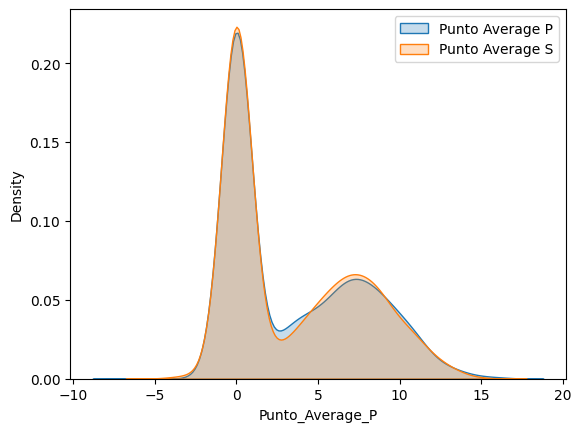

In [191]:
columnas = ['Punto Average P','Punto Average S']
for i, col in enumerate(punto_averages.columns):
    sns.kdeplot(punto_averages[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

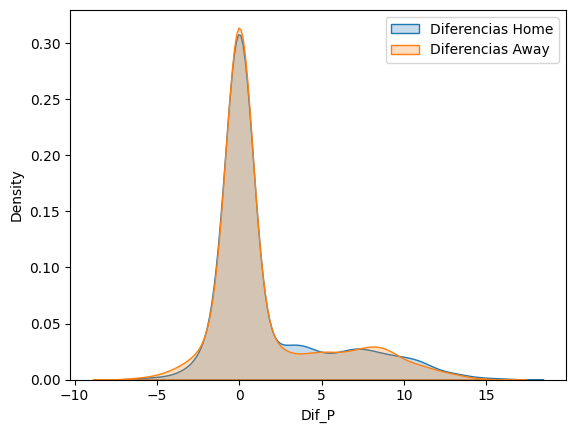

In [192]:
columnas = ['Diferencias Home','Diferencias Away']
for i, col in enumerate(diferencias.columns):
    sns.kdeplot(diferencias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

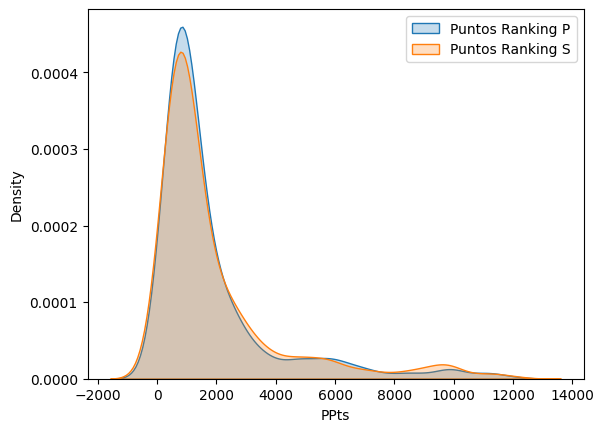

In [193]:
columnas = ['Puntos Ranking P','Puntos Ranking S']
for i, col in enumerate(puntos_rankings.columns):
    sns.kdeplot(puntos_rankings[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

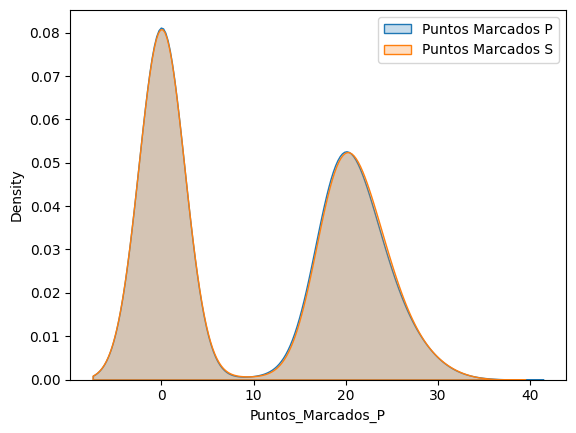

In [194]:
columnas = ['Puntos Marcados P','Puntos Marcados S']
for i, col in enumerate(puntos_marcados.columns):
    sns.kdeplot(puntos_marcados[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

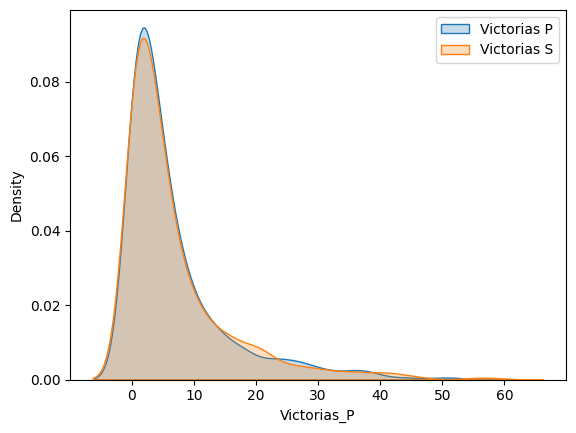

In [195]:
columnas = ['Victorias P','Victorias S']
for i, col in enumerate(victorias.columns):
    sns.kdeplot(victorias[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

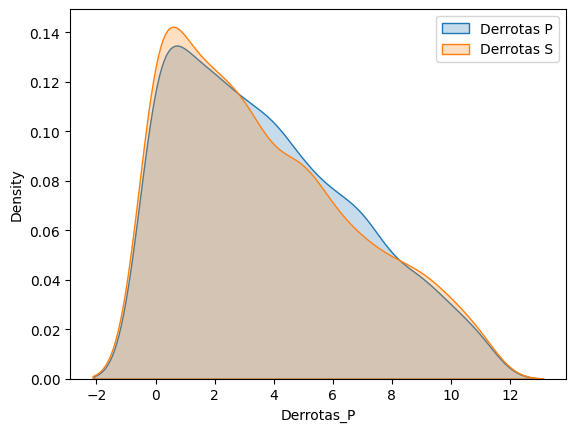

In [196]:
columnas = ['Derrotas P','Derrotas S']
for i, col in enumerate(derrotas.columns):
    sns.kdeplot(derrotas[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

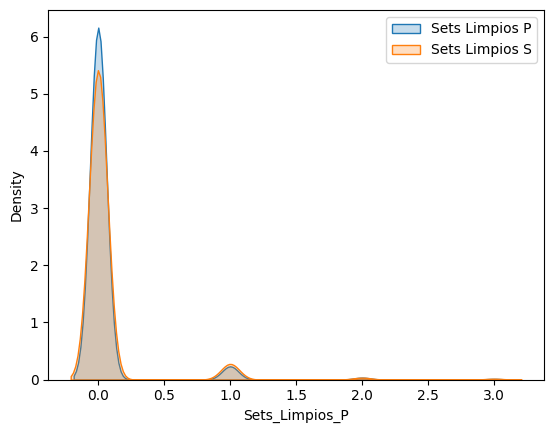

In [197]:
columnas = ['Sets Limpios P','Sets Limpios S']
for i, col in enumerate(sets_limpios.columns):
    sns.kdeplot(sets_limpios[col], fill=True, label=columnas[i])
plt.legend()
plt.show()

In [198]:
scale = MinMaxScaler().fit(features)
features_normalized = scale.transform(features)
features_normalized_dataframe = pd.DataFrame(features_normalized, columns=columnas_features)
features_normalized_dataframe.head()

,Punto_Average_P,Punto_Average_S,Dif_P,Dif_P,Puntos_Marcados_P,Puntos_Marcados_S,Victorias_P,Derrotas_P,Victorias_S,Derrotas_S,PPts,SPts,Punto_Average_Ultimos_5_P,Punto_Average_Ultimos_5_S
0,0.272727,0.210526,0.272727,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.026268,0.238570,0.272727,0.210526
1,0.272727,0.210526,0.272727,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.066833,0.055195,0.272727,0.210526
2,0.272727,0.210526,0.272727,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.034830,0.112136,0.272727,0.210526
3,0.272727,0.210526,0.272727,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.098504,0.066251,0.272727,0.210526
4,0.272727,0.210526,0.272727,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.131754,0.010806,0.272727,0.210526


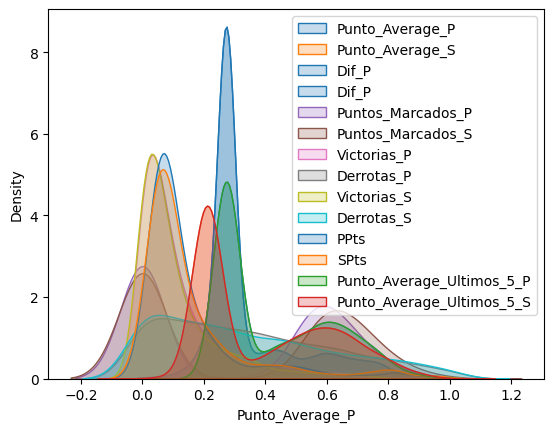

In [199]:
for i, col in enumerate(features_normalized_dataframe.columns):
    sns.kdeplot(features_normalized_dataframe[col], fill=True, label=columnas_features[i])
plt.legend()
plt.show()

In [200]:
onehot_encoder = OneHotEncoder(sparse_output=False)
equipos_encoded = onehot_encoder.fit_transform(np.array([tenistaP, tenistaS]).T)
equipos_encoded.shape

(1524, 494)

In [201]:
#predictores = np.concatenate([gol_average_home,gol_average_away,diferencia_home,diferencia_away,rojas_home,rojas_away], axis=1)
predictores = np.concatenate((features_normalized_dataframe[columnas_features].values,equipos_encoded), axis=1)

In [202]:
predictores.shape

(1524, 510)

In [203]:
original_feature_names = list(features_normalized_dataframe[columnas_features].columns)

# Nombres de las características categóricas
categorical_feature_names = ['local_team', 'visitor_team']

# Combina ambas listas
all_feature_names = original_feature_names + categorical_feature_names
equipos_locales = np.array(tenistaP)
equipos_visitantes = np.array(tenistaS)

# Concatenar las características numéricas con las categóricas
predictores_analisis = np.concatenate((features_normalized_dataframe[columnas_features].values, 
                              equipos_locales.reshape(-1, 1), 
                              equipos_visitantes.reshape(-1, 1)), axis=1)

In [204]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
selector = SelectFromModel(estimator=clf, threshold='mean') # puedes ajustar el umbral según lo desees
selector.fit(predictores, target)
predictores_selected = selector.transform(predictores)

In [205]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),  # Usamos 'macro' para el promedio entre clases
    'precision': make_scorer(precision_score, average='macro')  # Usamos 'macro' para el promedio entre clases
}

## - Entrenamiento del modelo

### División del dataset en entrenamiento y evaluación del modelo

In [206]:
features_train, features_test, target_train, target_test = train_test_split( predictores_selected, target, test_size=0.20, random_state=42)
print ('Train set:', features_train.shape,  target_train.shape)
print ('Test set:', features_test.shape,  target_test.shape)

Train set: (1219, 69) (1219,)
Test set: (305, 69) (305,)


### Definición y construcción del modelo

In [207]:
def get_modelo_regresion():
    model = LogisticRegression(max_iter=30, solver='liblinear', C=0.1, penalty='l1')
    return model

def get_modelo_random_forest():
    model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=6, criterion='log_loss')
    return model

def get_modelo_svc():
    model = SVC(kernel='linear', C=0.5, gamma='scale', probability=True)
    return model

def get_modelo_gbm(): ##mejores resultados pero tarda en entrenar
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)  
    return model

def get_modelo_decision_tree():
    model = DecisionTreeClassifier(criterion="log_loss",max_depth=13, random_state=42) 
    return model

def get_modelo_knn(): ##mejor recall en empates
    model = KNeighborsClassifier(n_neighbors=47, metric="minkowski", weights='uniform')
    return model

def get_modelo_naive_bayes():
    #model = GaussianNB()
    model = MultinomialNB()
    return model

def get_modelo_regresion_deep(features: pd.DataFrame) -> Sequential:
    numero_predictores = features.shape[1]
    #Crear el modelo
    model = Sequential()
    model.add(Dense(80, activation='relu', input_shape=(numero_predictores,)))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    #Compilar modelo
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])    
    return model

model = get_modelo_gbm()

### Entrenamiento del modelo

In [208]:
model.fit(features_train, target_train)
# iteraciones=4
# historial_entrenamiento=model.fit(features_train, target_train, validation_data=(features_test,target_test), epochs=iteraciones, verbose=1)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=200,
                           random_state=42)

In [209]:
#results = cross_validate(model, predictores, target, cv=kf, scoring=scoring, return_train_score=False)

## -Evaluación del modelo

### Evolución del modelo

In [210]:
target_pred = model.predict(features_test)
accuracy = accuracy_score(target_test, target_pred)
recal = recall_score(target_test, target_pred, average=None)
recal_total = recall_score(target_test, target_pred, average='macro')
precision = precision_score(target_test, target_pred, average=None)
precision_total = precision_score(target_test, target_pred, average='macro')
conf_matrix = confusion_matrix(target_test, target_pred)
print("Accuracy del modelo:", accuracy)
print("Recall del modelo:", recal)
print("Recall del modelo:", recal_total)
print("Precision del modelo:", precision)
print("Precision del modelo:", precision_total)
print("Matriz de Confusión:")
print(conf_matrix)

Accuracy del modelo: 0.6983606557377049
Recall del modelo: [0.72027972 0.67901235]
Recall del modelo: 0.6996460329793663
Precision del modelo: [0.66451613 0.73333333]
Precision del modelo: 0.6989247311827957
Matriz de Confusión:
[[103  40]
 [ 52 110]]


In [211]:
# print("Accuracy por fold:", results['test_accuracy'])
# print("Recall por fold:", results['test_recall'])
# print("Precision por fold:", results['test_precision'])

# print("\nAccuracy medio:", results['test_accuracy'].mean())
# print("Recall medio:", results['test_recall'].mean())
# print("Precision medio:", results['test_precision'].mean())

# print("\nDesviación estándar de Accuracy:", results['test_accuracy'].std())
# print("Desviación estándar de Recall:", results['test_recall'].std())
# print("Desviación estándar de Precision:", results['test_precision'].std())

## - Predicción real de un partido

In [212]:
P='Alcaraz C.'
S='Koepfer D.'
gol_average_home = dict_ultimo_punto_average_tenistas[P]
gol_average_away = dict_ultimo_punto_average_tenistas[S]
dif_home = dict_ultimas_diferencias_cada_tenistas[P]
dif_away = dict_ultimas_diferencias_cada_tenistas[S]
puntos_marcados_home = dict_ultimos_puntos_marcados_cada_tenistas[P]
puntos_marcados_away = dict_ultimos_puntos_marcados_cada_tenistas[S]
resultados_home = dict_ultimos_resultados_cada_tenistas[P]
resultados_away = dict_ultimos_resultados_cada_tenistas[S]
sin_encajar_P = dict_ultimo_sets_sin_encajar_tenistas[P]
sin_encajar_S = dict_ultimo_sets_sin_encajar_tenistas[S]
gol_average_5_P = dict_ultimo_gol_average_ultimos_5_equipo[P]
gol_average_5_S = dict_ultimo_gol_average_ultimos_5_equipo[S]

### Normalizar los predictores teniendo en cuenta los predictores usados para el entrenamiento del modelo

In [213]:
local = [P,]
visitante = [S,]
locales_encoded = label_encoder.transform(local)
visitantes_encoded = label_encoder.transform(visitante)

equipos_encoded = onehot_encoder.transform(np.array([locales_encoded, visitantes_encoded]).T)
equipos_encoded.shape

(1, 494)

In [214]:
datos_partido = np.array([
    gol_average_home, gol_average_away,
    dif_home, dif_away,
    puntos_marcados_home, puntos_marcados_away,
    resultados_home[0], resultados_home[1],
    resultados_away[0], resultados_away[1],
    sin_encajar_P, sin_encajar_S,
    gol_average_5_P, gol_average_5_S
]).reshape(1, -1)

datos_partido = scale.transform(datos_partido)

datos_list = datos_partido[0].tolist()

# Insertar puntos de ranking después de resultados_away[1] (índice 9)
datos_list.insert(10, dict_ultimos_puntos_ranking_cada_tenistas[P])
datos_list.insert(11, dict_ultimos_puntos_ranking_cada_tenistas[S])

datos_partido = np.array(datos_list).reshape(1, -1)

print(datos_partido.shape)

(1, 16)


c:\Users\User\OneDrive\Escritorio\TFG\Cosas_TFG\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [215]:
predictores = np.concatenate((datos_partido, equipos_encoded), axis=1)
predictores.shape

(1, 510)

In [216]:
predictores_selected = selector.transform(predictores)
predictores_selected.shape

(1, 69)

### Predicción del valor objetivo

In [217]:
pred1 = model.predict_proba(predictores_selected)
pred1

array([[0.29618151, 0.70381849]])

### Conversión del número devuelto
Puede que el valor de las probabilidades devuelto por el modelo sea muy pequeño así que se opera para ser un número más manejable

In [218]:
def convertir_numbero(prediccion: list) -> list:
    prediccion_valores=[]
    for i in range(len(prediccion[0])):
      pred_number=float(format(prediccion[0][i], '.3f'))
      prediccion_valores.append(pred_number)

    return (prediccion_valores)
  
pred1_number_probabilities=convertir_numbero(pred1)

### Obtención del resultado predicho en base a las probabilidades predichas por el modelo

In [219]:
def get_ganador_prediccion(ganador: list) -> str:
    y=ganador.index(max(ganador))
    if y==0:
        pred_winner='S'
    else:
        pred_winner='P'
    return pred_winner

ganador_predicho=get_ganador_prediccion(pred1_number_probabilities)

### Resultado Final

In [220]:
#print('El ganador real es: ', ganador_real)
print('El ganador predicho es: ',ganador_predicho)

El ganador predicho es:  P


### Visualización de las probabilidades en una gráfica

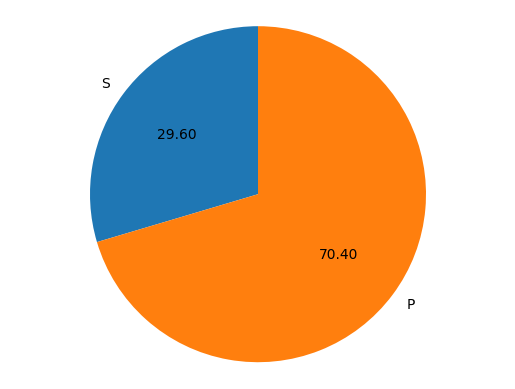

In [221]:
etiquetas = 'S','P'
figureObject, axesObject = plt.subplots()
axesObject.pie(pred1_number_probabilities, labels=etiquetas, autopct='%1.2f', startangle=90)
axesObject.axis('equal') # Aspect ratio equal means pie is a circle
plt.show()